In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random

### Arquivos já estão divididos em treino, validação e teste.

In [ ]:
src_path1 = '/content/gdrive/MyDrive/TrabalhoFinal_CleanDataset'
train_path = os.path.join(src_path1, 'train_v2')
train_path_emp = os.path.join(train_path, 'empresas')
train_path_Nemp = os.path.join(train_path, 'nao_empresas')

#src_path = '/content/gdrive/MyDrive/619_ProjetoFinal/Dados_ProjetoFinal/split_train_val_test'
src_path = '/content/gdrive/MyDrive/Dados_ProjetoFinal_MDC010-INF019/split_train_val_test'
val_path = os.path.join(src_path, 'val')
test_path = os.path.join(src_path, 'test')

val_path_emp = os.path.join(val_path, 'imagens_empresas')
val_path_Nemp = os.path.join(val_path, 'imagens_nao_empresas')

test_path_emp = os.path.join(test_path, 'imagens_empresas')
test_path_Nemp = os.path.join(test_path, 'imagens_nao_empresas')

In [ ]:
print('Número de imagens de empresas (treinamento):', len(os.listdir(train_path_emp)))
print('Número de imagens de não empresas (treinamento):', len(os.listdir(train_path_Nemp)))
print('Número de imagens de empresas (validacao):', len(os.listdir(val_path_emp)))
print('Número de imagens de não empresas (validacao):', len(os.listdir(val_path_Nemp)))
print('Número de imagens de empresas (teste):', len(os.listdir(test_path_emp)))
print('Número de imagens de não empresas (teste):', len(os.listdir(test_path_Nemp)))

Número de imagens de empresas (treinamento): 2689
Número de imagens de não empresas (treinamento): 3849
Número de imagens de empresas (validacao): 909
Número de imagens de não empresas (validacao): 1291
Número de imagens de empresas (teste): 910
Número de imagens de não empresas (teste): 1292


#### Imprimindo algumas imagens usadas no treino:

In [ ]:
numeroFiguras = 4

arrImagEmp = os.listdir(train_path_emp)
arrImagEmp = random.sample(arrImagEmp, numeroFiguras)
print(arrImagEmp)

arrImagNEmp = os.listdir(train_path_Nemp)
arrImagNEmp = random.sample(arrImagNEmp, numeroFiguras)
print(arrImagNEmp)

['1511.jpg', '1134.jpg', '6197.jpg', '3002.jpg']
['1244.jpg', '2199.jpg', '6334.jpg', '5803.jpg']


Imagens de empresas:


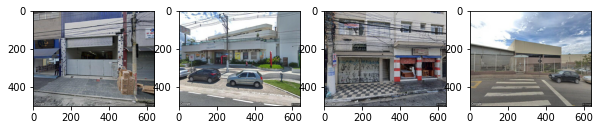

In [ ]:
fig = plt.figure(figsize=(10,5))

print("Imagens de empresas:")
for i in range(4):
    # Imagens de empresas:
    plt.subplot(240 + 1 + i)
    img = plt.imread(os.path.join(train_path_emp,arrImagEmp[i]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))

Imagens de não empresas:


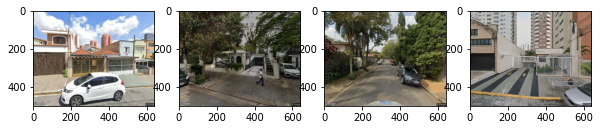

In [ ]:
fig = plt.figure(figsize=(10,5))

print("Imagens de não empresas:")
for i in range(4):
    # Imagens de não empresas:
    z = i + 4
    plt.subplot(240 + 1 + z)
    img = plt.imread(os.path.join(train_path_Nemp,arrImagNEmp[i]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))

### Gerando dados de treino e validação.

In [ ]:
#Leitura e preprocessamento das imagens
import tensorflow as tf
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

def plotImages(imgList, n_row=1, n_col=1):
    _, axs = plt.subplots(n_row, n_col, figsize=(25, 5))
    axs = axs.flatten()
    for img, ax in zip(imgList, axs):
        ax.imshow(np.uint8((img+1)*127.5), interpolation='nearest')
    plt.show()

## Modelo com  ResNet50 Descongelada.

In [ ]:
#Preprocessamento para ResNet50
train_datagen4 = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

## flow_from_directory ##
train_generator4 = train_datagen4.flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True)
batch_X_proc, batch_Y_proc = train_generator4.next()

validation_generator4 = train_datagen4.flow_from_directory(directory=val_path, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)
batch_val_X_proc, batch_val_Y_proc = validation_generator4.next()

print(batch_X_proc.shape, batch_Y_proc.shape)

Found 6538 images belonging to 2 classes.
Found 2200 images belonging to 2 classes.
(32, 224, 224, 3) (32, 2)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
#Pesos para Balanceamento das classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator4.labels), y=train_generator4.labels)
train_class_weights = dict(enumerate(class_weights))
print('train_class_weights: ', train_class_weights)

train_class_weights:  {0: 1.2156935663815545, 1: 0.8493115094829826}


In [ ]:
#Modelo com fine-tuning
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in model.layers:
    layer.trainable = True

model4 = tf.keras.Sequential([model, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dropout(.5), tf.keras.layers.Dense(2, activation='softmax')])    
model4.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
#Instancia um otimizador SGD e compila o modelo completo
sgd = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, decay=0.001, nesterov=True)
model4.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=[tf.keras.metrics.AUC(),'accuracy'])

In [ ]:
#Treinamento
history4 = model4.fit(train_generator4, epochs=25, batch_size=32, validation_data=validation_generator4, class_weight=train_class_weights)

Epoch 1/25
205/205 [==============================] - 81s 360ms/step - loss: 0.6726 - auc_3: 0.7330 - accuracy: 0.6695 - val_loss: 0.4201 - val_auc_3: 0.8897 - val_accuracy: 0.8127
Epoch 2/25
205/205 [==============================] - 73s 358ms/step - loss: 0.4987 - auc_3: 0.8531 - accuracy: 0.7762 - val_loss: 0.3987 - val_auc_3: 0.9021 - val_accuracy: 0.8218
Epoch 3/25
205/205 [==============================] - 74s 361ms/step - loss: 0.4458 - auc_3: 0.8824 - accuracy: 0.8030 - val_loss: 0.3812 - val_auc_3: 0.9108 - val_accuracy: 0.8350
Epoch 4/25
205/205 [==============================] - 73s 353ms/step - loss: 0.4073 - auc_3: 0.9011 - accuracy: 0.8215 - val_loss: 0.3649 - val_auc_3: 0.9183 - val_accuracy: 0.8409
Epoch 5/25
205/205 [==============================] - 72s 350ms/step - loss: 0.3778 - auc_3: 0.9143 - accuracy: 0.8337 - val_loss: 0.3605 - val_auc_3: 0.9208 - val_accuracy: 0.8400
Epoch 6/25
205/205 [==============================] - 73s 355ms/step - loss: 0.3455 - auc_3: 0.

In [ ]:
import h5py
# serialize weights to HDF5
model4.save_weights("/content/gdrive/MyDrive/INF 0619-010 - Trabalho Final - Zanoni/Modelos/model_ResNet50_Desc_Clean.h5")
print("Saved model to disk")

Saved model to disk


69/69 - 17s - loss: 0.3539 - auc_3: 0.9303 - accuracy: 0.8564 - 17s/epoch - 251ms/step


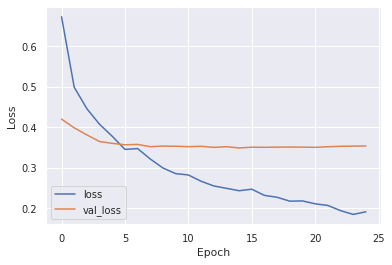

In [ ]:
#Resultado do modelo
plt.plot(history4.history['loss'], label='loss')
plt.plot(history4.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')

loss, auc, acc = model4.evaluate(validation_generator4, verbose=2)

In [ ]:
#Acurácia Balanceada

#Reseta o gerador para gerar os dados usados no nosso predict.
validation_generator4.reset()

#Faz a predição à partir dos dados do nosso gerador.
y_pred_sa = model4.predict(validation_generator4)

# Converte os valores preditos para números inteiros nos valores de 0 ou 1.
y_pred_int_sa = (y_pred_sa > 0.5).astype(np.int32) 

# A lista acima é formada por listas de tamanho 2 onde nos interessa apenas o segundo item de cada lista, portanto o que fazemos nesse trecho é gerar 
# uma nova lista de inteiros selecionando apenas o 2º item de cada lista presente no y_pred_nn.
y_pred_nn_sa = []
for item in y_pred_int_sa:
    y_pred_nn_sa.append(item[1])  

In [ ]:
# Novamente faz o reset do gerador para puxarmos os dados do target.
validation_generator4.reset()

# Gera uma lista com os rótulos de cada imagem.
Y_val = []

while True:
    x,y = validation_generator4.next()
    
    new_list = []
    for item in y:
        new_list.append(item)
        
    Y_val += new_list
    if len(Y_val) > 2200:
        break

In [ ]:
# Acurácia balanceada
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(validation_generator4.labels, y_pred_nn_sa, sample_weight=None, adjusted=False)

0.8532005020796425

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=4,suppress=True)

# Matriz de confusão
cm = confusion_matrix(validation_generator4.classes, y_pred_nn_sa)



Acurácia balanceada: 0.8532


Matriz de confusão balanceada


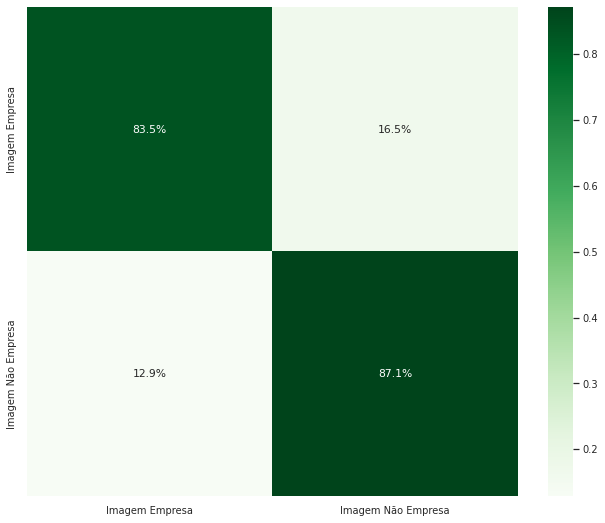

In [ ]:
# Matriz de confusão normalizada
num_classes=2
categories = ['Imagem Empresa', 'Imagem Não Empresa']
cmn = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
balanced_acc = np.trace(cmn) / num_classes
print("\n\nAcurácia balanceada:", round(balanced_acc,4))

print("\n\nMatriz de confusão balanceada")
plt.figure(figsize = (11,9))
sns.set(font_scale=0.9)
sns.heatmap(cmn, annot=True, fmt='.1%', xticklabels=categories, yticklabels=categories, cmap='Greens')

In [ ]:
#AUC-ROC
from sklearn.metrics import roc_curve
fpr, tpr, thresh = roc_curve(validation_generator4.classes, y_pred_sa[:,1], pos_label=1)

from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(validation_generator4.classes, y_pred_sa[:,1])
print(auc_score)

0.9281660544055956


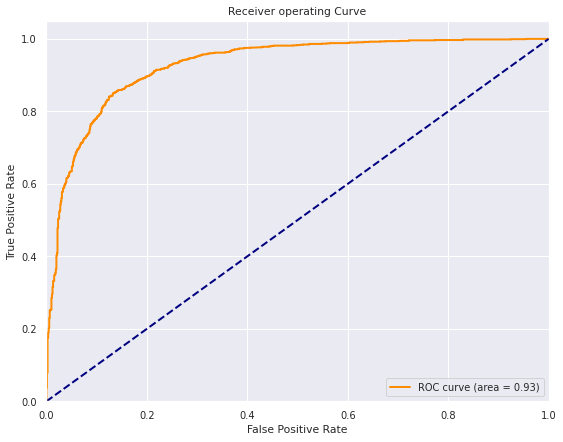

In [ ]:
plt.figure(figsize = (9,7))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc_score,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating Curve")
plt.legend(loc="lower right")
plt.show()